In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt #一个常用的绘图库，能够生成各种静态、动态和交互式的图形。

In [2]:
# 读取数据
df = pd.read_csv('data.csv')

In [3]:
# 提取特征
def extract_features(url):
    length = len(url)  # URL长度
    contains_digit = int(bool(re.search(r'\d', url)))  # 是否包含数字
    special_chars = len(re.findall(r'[-_?&=]', url))  # 特殊字符数量
    domain = re.search(r'https?://([^/]+)', url)  # 提取域名
    domain_count = 0
    
    if domain:
        domain_parts = domain.group(1).split('.')
        domain_count = len(domain_parts)
    
    return [length, contains_digit, special_chars, domain_count]

In [4]:
# 提取所有URL的特征
features = df['url'].apply(extract_features)

In [5]:
# 转换为NumPy数组
features = np.array(features.tolist())

In [6]:
# 标签转换为数值类型：0为bad, 1为good
labels = np.array([1 if label == 'good' else 0 for label in df['label']])

In [7]:
# 数据标准化
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [8]:
# 划分训练集和测试集
def train_test(X, y, test_size=0.3, random_state=None):
    np.random.seed(random_state)
    total_samples = len(X)
    test_samples = int(total_samples * test_size)
    indices = np.random.permutation(total_samples)
    
    test_indices = indices[:test_samples]
    train_indices = indices[test_samples:]
    
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test(features, labels, test_size=0.3, random_state=42)

In [9]:
# 神经网络参数初始化
input_size = X_train.shape[1]  # 输入层大小
hidden_size = 5  # 隐藏层神经元个数
output_size = 1  # 输出层大小
learning_rate = 0.01 # 每次参数更新的步长
iterations = 1000 # 训练过程中的迭代次数，更新权重 1000 次

In [10]:
# 初始化权重和偏置
np.random.seed(520) #使用任何固定的数字
W1 = np.random.randn(input_size, hidden_size)  # 输入到隐藏层的权重
b1 = np.zeros((1, hidden_size))  # 隐藏层偏置，形状为 (1, hidden_size)，初始化为零
W2 = np.random.randn(hidden_size, output_size)  # 隐藏层到输出层的权重
b2 = np.zeros((1, output_size))  # 输出层偏置，形状为 (1, output_size)，初始化为零

In [11]:
# Sigmoid激活函数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Sigmoid的导数，对于神经网络的反向传播，我们需要用到激活函数的导数来计算梯度并更新权重。
def sigmoid_derivative(x):
    return x * (1 - x)

In [12]:
# 前向传播：通过输入数据计算每一层的输出，最终得到模型的预测结果 A2。
def forward(X):
    Z1 = np.dot(X, W1) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2)
    return A1, A2

# 反向传播：通过计算误差并反向传播，得到每一层的梯度，帮助优化模型参数（。
def backward(X, y, A1, A2):
    m = X.shape[0]
    
    dZ2 = A2 - y.reshape(-1, 1)
    dW2 = (1 / m) * np.dot(A1.T, dZ2)
    db2 = (1 / m) * np.sum(dZ2, axis=0, keepdims=True)
    
    dZ1 = np.dot(dZ2, W2.T) * sigmoid_derivative(A1)
    dW1 = (1 / m) * np.dot(X.T, dZ1)
    db1 = (1 / m) * np.sum(dZ1, axis=0, keepdims=True)
    
    return dW1, db1, dW2, db2

In [13]:
# 用来存储每次迭代的代价（用于绘图）
costs = []

In [14]:
# 训练神经网络
for i in range(iterations):
    # 前向传播
    A1, A2 = forward(X_train)
    
    # 计算误差和梯度
    dW1, db1, dW2, db2 = backward(X_train, y_train, A1, A2)
    
    # 更新权重和偏置
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    # 每100次迭代打印一次代价（这里只计算最后一层的误差）
    if i % 100 == 0:
        cost = np.mean((A2 - y_train.reshape(-1, 1)) ** 2)
        costs.append(cost)
        print(f"Iteration {i} | Cost: {cost}")

Iteration 0 | Cost: 0.6038398717272119
Iteration 100 | Cost: 0.3414924486276535
Iteration 200 | Cost: 0.20846498287231444
Iteration 300 | Cost: 0.16647284129258516
Iteration 400 | Cost: 0.15295675181883764
Iteration 500 | Cost: 0.14807654684177166
Iteration 600 | Cost: 0.1461289795624167
Iteration 700 | Cost: 0.14528492767498244
Iteration 800 | Cost: 0.14488681417324467
Iteration 900 | Cost: 0.14467661832060877


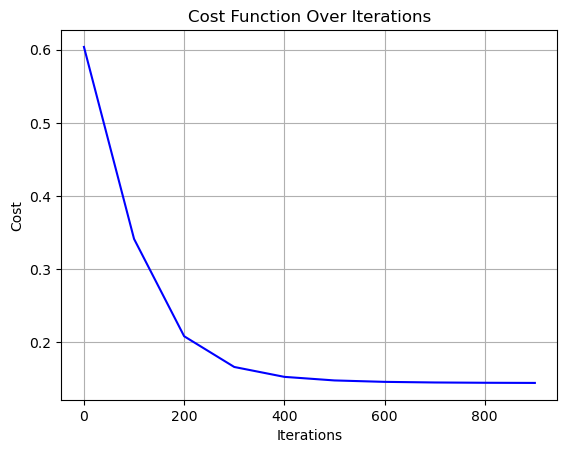

In [15]:
# 绘制代价函数变化图
plt.plot(range(0, iterations, 100), costs, color='blue')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Function Over Iterations')
plt.grid(True)
plt.show()

In [16]:
# 测试神经网络
def predict(X):
    _, A2 = forward(X)
    return (A2 >= 0.5).astype(int)

# 预测结果
y_pred = predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'Neural Network Accuracy: {accuracy * 100:.2f}%')

Neural Network Accuracy: 82.19%
